## Markov Decision Process 
The state transition and reward models $R$ and $T$ are known.

### Value Iteration
The value function $U(s)$ represents the long-term reward that the agent is going to get if he starts in $s$ and follows the optimal policy.  

The value iteration approach keeps improving the value function at each iteration until it converges.
At each iteration and for each state s we update its estimated utility:  
  $$U_{t+1}(s) = \max_{a}\sum_{s'}T(s, a, s')(R(s') + \gamma U_t(s')) $$  


In [7]:
def value_iteration(env, gamma, max_iter, epsilon):
    U = np.zeros(env.nS)
    for i in range(max_iter):
        prev_U = np.copy(U)
        for s in range(env.nS):
            list_sum = np.zeros(env.nA)
            for a in range(env.nA):
                for p, s_prime, r, _ in env.P[s][a]:
                    list_sum[a] += p*(r + gamma*prev_U[s_prime])
            U[s] = max(list_sum)
        if (np.sum(np.fabs(prev_U - U)) <= epsilon):
            break
    return U     

Once we have computed the true utility of each state $U(s)$ we can figure out the optimal policy $\pi(s) = \underset{a}{\operatorname{argmax}}U(s) =  \underset{a}{\operatorname{argmax}}\sum_{s'}T(s, a, s')(R(s')+\gamma U(s'))$
### Policy Iteration
If we compute the true utility of each state $U(s)$ we can figure out the optimal policy but we have much more information than what we need to figure out the optimal policy.  
The policy iteration approach re-defines the policy at each step and computes the value function associated to the current policy until the policy converges to the optimal policy.
It needs less iterations than VI to converge however each iteration is more computationally expensive.  
Given a policy $\pi_t$ we compute the utility of each state:  
  $$U_t(s) = \sum_{s'}T(s, \pi_t(s), s')(R(s') + \gamma U_t(s')) $$

In [8]:
def evaluate_policy(env, policy, gamma, epsilon):
    U = np.zeros(env.nS)
    while True:
        prev_U = np.copy(U)
        for s in range(env.nS):
            a = policy[s]
            U[s] = sum([p * (r + gamma * prev_U[s_]) for p, s_, r, _ in env.P[s][a]])
            #for p, s_prime, r, _ in env.P[s][a]:
                #U[s] += p*(r + gamma*prev_U[s_prime])
        if (np.sum(np.fabs(prev_U - U)) <= epsilon):
            break
    return U

We then improve the policy:  
$$ \pi_{t+1}(s) = \underset{a}{\operatorname{argmax}}\sum_{s'}T(s, a, s')(R(s') + \gamma U_t(s'))$$

In [9]:
def improve_policy(U, gamma):
    policy = np.zeros(env.nS)
    for s in range(env.nS):
        list_sum = np.zeros(env.nA)
        for a in range(env.nA):
            for p, s_prime, r, _ in env.P[s][a]:
                list_sum[a] += p*(r+gamma*U[s_prime])
        policy[s] = np.argmax(list_sum)
    return policy


To get the final Policy Iteration algorithm we combine the two previous steps:

In [10]:
def policy_iteration(env, gamma, max_iter, epsilon):
    policy = np.random.choice(env.nA, env.nS)
    for i in range(max_iter):
        U = evaluate_policy(env, policy, gamma, epsilon)
        new_policy = improve_policy(U, gamma)
        if (np.all(policy == new_policy)):
            break
        policy = new_policy
    return policy


## Reinforcement Learning - Value Optimization
The state transition and reward models $T$ and $R$ are not known. The agent has access to the set of possible states and actions and has to learn through interactions with the environment.

### Q-Learning

The Q-Learning algorithm does no longer have access to the models of the MDP that is to say the transition and reward functions.
The idea is now to evaluate the Bellman equation from data by using transitions (data : $ <s, a, r, s'>$) to produce the solutions to the Q equations.
At each episode we are going to update the estimates of the Q function coming from the previous episode through a learning rate $\alpha$. 
$$ Q(s, a) = \alpha(r + \gamma \max_{a'}Q(s', a')) + (1 - \alpha)Q(s, a)$$


In [16]:
def q_learning(env, alpha, gamma, nb_episodes, nb_steps, epsilon, epsilon_min, epsilon_decay):
    
    # Initialize the Q-table with zeros
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    
    for i in range(nb_episodes):
        s = env.reset() #Initial observation
        for j in range(nb_steps):
            # The action associated to s is the one that provides the best Q-value with a proba 1-epsilon and is random with a proba epsilon
            if random.random() < 1 - epsilon:
                a = np.argmax(Q[s,:]) 
            else : 
                a = np.random.randint(env.action_space.n)
            # We get our transition <s, a, r, s'>
            s_prime, r, d, _ = env.step(a)
            # We update the Q-tqble with using new knowledge
            Q[s, a] = alpha*(r + gamma*np.max(Q[s_prime,:])) + (1 - alpha)*Q[s, a]
            s = s_prime
            if d == True:
                break
            if (epsilon > epsilon_min):
                epsilon *= epsilon_decay
    
    return Q


### Deep Q-Learning

The problem of the previous Q-Learning algorithm is that it will not be able to work in big state space environments.
So rather than using a Q-table which returns a Q-value for a given state and a given action we can implement a neural network $N$ which takes a state and returns the Q-values of all the possible actions that could be taken in that state: $N(s) = \{Q(s, a_1), Q(s, a_2), ..., Q(s, a_n)\}$.   
  Just as Q-Learning we start with an initial state $s$ and action $a$. We look at the next state $s'$ and the associated reward $r$ that the agent receives when he takes this action $a$ in the state $s$.
  The transition $<s, a, r, s'>$ is stored in the memory of the agent. When we start to have enough transitions in the memory we sample a batch of them and for each transition $<s, a_j, r, s'>$ we do the following:  
   - Compute a target $t$, which represents the "best" action that can be done when the agent is in $s$, that is to say the action that maximizes the expected long-term reward.  
   $t = r +\gamma \max_a Q(s',a)$ with $\{Q(s', a_i)\}_{i = 1, ..., n} = N(s')$
   - Compute the output predicted by the network for $s$: $N(s) = \{Q(s, a_i)\}_{i = 1, ..., n}$ 
   - Replace $Q(s, a_j)$ with $t$ to get $N'(s)$
   - Train the network using $s$ as the input and $N'(s)$ as the output.  

We then use $s'$ as the current state $s$ and reiterate.

In [43]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

#### Target network
Two networks are created. The first one is used to get the Q-values while the second one includes all updates in the training.
The parameters of the target network $\theta^-$ are copied every $\tau$ updates from the online network and kept fixed on all other steps.
Thanks to this target network the Q-value targets are fixed temporarily so that we do not have a moving target to chase. For each transition $<s, a_j, r, s'>$ we do the following:
- Use the target network to compute a target $t = r +\gamma \max_a Q(s',a; \theta^-)$
- Use the online network to predict the output for $s$: $\{Q(s, a_1;\theta), ..., Q(s, a_n;\theta)\}$
- Replace $Q(s, a_j;\theta)$ with $t$ to get the corrected output for $s$
- Train the online network using $s$ as the input and the corrected output as the output

### Double Deep Q-Learning
The goal of Double Q-Learning is to reduce overestimations made on action values by DQL by decomposing the max operation present in the target $t$ into action selection and action evaluation.  
Indeed the target computed using DQL can be written as $t_{DQL} = r+\gamma\max_aQ(s',a;\theta)$ where $\theta$ represent the parameters of the network.  
In the DDQL algorithm two sets of weights $\theta$ and $\theta'$ are used, one to determine the greedy policy and the other one to determine its value. 
The Double Q-learning target can thus be written $t_{DDQL} = r + \gamma Q(s', \underset{a}{\operatorname{argmax}}Q(s',a;\theta) ;\theta')$. 
So we use one network to see which action $a$ maximizes the Q value associated to $s'$ and another network to evaluate the value of that action when it is associated to $s'$. For instance we could used the online network as $\theta$ and the target network $\theta^-$ as $\theta'$.

### Dueling Network Architectures
Notations: The advantage function $A^{\pi}(s,a) = Q^{\pi}(s,a) - U^{\pi}(s)$ subtracts the value that we get when we are in $s$ and follow $\pi$ from the value that we get when we are in $s$, do $a$ and then follow $\pi$. The advantage function thus measures the importance of each action.  
Instead of using conventional architectures for DQL the idea is to use a dueling network representing two separate estimators. 
The state value function $U(s)$ is estimated separately from the state-dependent action advantage function $A(s,a)$.
The idea is to allow the architecture to learn which states are valuable without having to learn the effect of each action for each state.  
The two streams of the dueling Q-network are then combined via an aggregating layer to produce an estimate of $Q(s,a)$.  

For many states it is unnecessary to estimate the value of each action choice however it is often important to estimate state values for every state. The state values are approximated in a better way thanks to this dueling architecture. In the classic architecture only the value for one of the action is updated and the values for the other actions remained untouched. Here the state values are updated with each update of the Q values.

### Prioritized experience replay
With $DQL$ we sample uniformly from the replay buffer while we would like to sample more frequently transitions from which there is much to learn.
The priority of a transition $<s,a,r,s'>$ can be expressed as $p_i = |r + \gamma \max_{a'}Q(s,a';\theta) - Q(s, a;\theta^-)|$. The probability for this transition to be chosen for replay is thus $p = \frac{p_i^{\omega}}{\sum_kp_k^{\omega}}$ with $\omega$ a hyper-parameter used to reintroduce randomness in the selection of the transitions. If $\omega=0$ the transitions are selected randomly but if $\omega=1$ only the transitions with the highest priorities are selected.  
We also need to reduce the weights of the examples which are often seen to be sure that we do not update the weights only with a small portion of transitions that we believe are important.
In order to do that we use importance sampling weights: $(\frac{1}{N}.\frac{1}{p})^b$. At the beginning of the learning $b=0$ so that these weights do not affect the sampling but at the end of the learning when the Q values begin to converge $b$ is set closer to $1$ so that we do not keep sampling the same group of transitions to train the network.
### Distributional Q-Learning
Remember, $Q^{\pi}(s,a)$ represents the expected value of the total future rewards that we get if we are in $s$, do $a$ then follow the policy $\pi$.  
It would be more interesting to model the distribution of the total future rewards rather than restrict ourselves to the expected value which is the Q function.
Indeed if the environment is stochastic and the distribution of future rewards follows a multimodal distribution then choosing actions based on expected value may lead to suboptimal outcomes.  
A random variable $Z(s,a)$ called the Value Distribution is thus used instead of $Q(s,a)$ in the Bellman equation. $Z(s,a)$ which is no longer a scalar quantity like $Q(s,a)$ can be represented as a discrete distribution parameterized by a number of discrete values.  
When does the distributional part come into play and make the network smarter about selecting the actions ?

## Reinforcement Learning - Policy Optimization
The idea is to consider parametric policies $\pi_{theta}$ so that when we are in a state $s$ we can choose an action $a$ according to a parameter vector $\theta$ of $n$ parameters. Te goal is thus to tune this vector of parameters $\theta$ in order to select the best action to take for policy $\pi$.
Policy-based methods allow us to directly learn the policy function mapping states to actions without having to learn a value function telling us what is the expected sum of rewards given a state and an action.  
Advantages:  
- Better convergence properties
- More effective in high-dimensional or continuous action spaces since the goal is to learn a set of parameters and not to assign a score for each possible action given the current state.
- Able to learn stochastic policies while value functions can not.  

Disadvantages:
- Often converge on a local maximum rather than on the global optimum

### Policy Gradient

The goal of policy gradient algorithms is to optimize parameterized policies with respect to the long-term cumulative reward. $\pi_{\theta}(a|s)$ outputs the probability of taking action $a$ given state $s$ with parameters $\theta$. We have to find the best parameters $\theta$ to maximize a score function $J(\theta)$.  
The first step is thus to measure the quality of a policy $\pi$ with a score function $J(\theta)$ and the second step is to use policy gradient ascent to find the best parameter $\theta$ that improves $\pi$.  
The score function can also be written: $J(\theta) = E_{\pi}(Q^{\pi}(s,a)) = \sum_sd^{\pi}(s)\sum_a \pi_{\theta}(a|s)Q^{\pi}(s,a)$ where $d^{\pi}(s)$ represents the state distribution under $\pi$.  
We can show that $\nabla_{\theta}J(\theta) \propto E_{\pi}(Q^{\pi}(s,a)\nabla_{\theta}\ln \pi_{\theta}(a|s))$  
The parameters of the policy are then updated the following way: $\theta_{k+1} = \theta_k + \alpha_k\nabla_{\theta}J(\theta_{k})$  
Policy Gradient algorithms cause the parameters to move most in the direction that favors actions with the highest returns.

#### Reinforce (Monte-Carlo policy gradient)
This method uses real sample trajectories to update the policy parameter $\theta$.
Algorithm:
- Initialize the policy parameter $\theta$ at random
- Generate one trajectory on policy $\pi_{\theta}$: $S_1, A_1, R_2, S_2, A_2, ..., S_T$
- For $t=1, 2, ..., T$:
    - Estimate $G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2R_{t+3} + ...$ 
    - Update the parameter $\theta = \theta + \alpha G_t \nabla_{\theta}\ln \pi_{\theta}(A_t|S_t)$

#### Actor Critic 
This method possesses two models:
- Critic updates the value function parameters $\omega$
- Actor updates the policy parameters $\theta in the direction suggested by the value function  

Algorithm:
- Initialize $s, \theta, \omega$ at random, sample $a$ according to $\pi_{\theta}(a|s)$
- For $t=1, ..., T$:
    - Sample reward $r$ and next state $s'$
    - Sample the next action $a'$ according to $\pi_{\theta}(a'|s')$
    - Update the policy parameters $\theta = \theta + \alpha_{\theta}Q_{\omega}(s,a)\nabla_{\theta}\ln\pi_{\theta}(a|s)$
    - Compute the correction for the Q-function: $\delta = r + \gamma Q_{\omega}(s',a') - Q_{\omega}(s,a)$  
    Update the parameters of the value function: $\omega = \omega + \alpha_{\omega}\delta_t\nabla_{\omega}Q_{\omega}(s,a)$
    - $a = a'$ and $s = s'$

#### Off-Policy Policy Gradient
Unlike the two previous methods this method does not collect training samples according to the policy that we try to optimize for. Instead it uses a behavioral policy $\beta(a|s)$ to collect training observations. 
The score of the policy that we try to optimize is thus defined as $J(\theta) = E_{s\beta}(Q^{\pi}(s,a)) = \sum_sd^{\beta}(s)\sum_a \pi_{\theta}(a|s)Q^{\pi}(s,a)$  
The gradient can be rewritten as $\nabla_{\theta}J(\theta) = E_{\beta}(\frac{\pi_{\theta}(a|s)}{\beta(a|s)}Q^{\pi}(s,a)\nabla_{\theta}\ln \pi_{\theta}(a|s))$
     
#### Asynchronous Advantage Actor-Critic
This method focuses on parallel training.  
We start by constructing a global network with two output layers, one for the value function and one for the policy. Then a set of agents possessing their own network and environment are created. Each of these workers run on a separate processor thread.  
To start with each worker sets its network parameters to the ones of the global network. Then the workers interact with their copy of the environment and collect experiences $(s, a, r, s', \mbox{done}, \mbox{value})$ to compute value and policy losses which are then used to get gradients.
Each worker uses these gradients to update the global network's parameters.  
Once an update is made the worker resets its network parameters to the ones of the global network and the process repeats.

#### Deterministic Policy Gradient
This method models the policy as a deterministic decision: $\pi(s) =\mu(s) = a$
#### Deep Deterministic Policy Gradient
This off-policy actor critic algorithm combines Deterministic Policy Gradient with Deep Q-Network.
#### Proximal Policy Optimization
The idea is to avoid parameter updates that change the policy too much at one step.
#### Actor Critic with experience replay
This method is A3C's off-policy counterpart.
#### Soft Actor Critic
This is an off-policy actor critic model following the maximum entropy reinforcement learning framework. 
## Gym environments

### Frozen Lake - 16 states


In [11]:
import gym
import numpy as np
import random

env = gym.make('FrozenLake-v0')


#### Description
States: There are 16 different states that represent the different parts of the lake. An agent wants to go from a starting point (S) to a goal (G) situated on the other side of the lake.
Some states are traversable (F) but others are holes (H) that lead the agent to fall into the water.
The surface can be represented using the following grid:  
  SFFF  
  FHFH  
  FFFH  
  HFFG

Actions: There are 4 different actions that the agent can do when he is in a state: [LEFT, DOWN, RIGHT, UP].

Transition model: If the agent wishes to execute an action, this action is executed correctly with a probability of 0.8 and causes the agent to move at a right angle with a probability of 0.2.
The 0.2 is distributed uniformly over the two possible right angles.

Rewards: +1 if the agent reaches the goal, -1 if the agent falls down a hole and -0.04 if the agent is on a frozen surface.

#### Value Iteration

In [12]:
env = env.unwrapped
gamma = 0.99
max_iter = 100000
epsilon = 1e-20
print(value_iteration(env, gamma, max_iter, epsilon))

[0.2223427  0.04871172 0.22713291 0.04871172 0.29735898 0.
 0.32511109 0.         0.51000055 0.77848739 0.7034231  0.
 0.         0.88176572 0.95631397 0.        ]


To visualize the policy produced by this utility:

In [14]:
def visualize_policy(policy):
    visu = ''
    for k in range(len(policy)):
        if k > 0 and k%4 == 0:
            visu += '\n'
        if k == 5 or k == 7 or k == 11 or k == 12 or k == 15:
            visu+='H'
        elif int(policy[k]) == 0:
            visu += 'L'
        elif int(policy[k]) == 1:
            visu += 'D'
        elif int(policy[k]) == 2:
            visu += 'R'
        elif int(policy[k]) == 3:
            visu += 'U'
    print(visu)
    
U = value_iteration(env, gamma, max_iter, epsilon)
policy = improve_policy(U, gamma)
visualize_policy(policy)

DRDL
DHDH
RDLH
HRRH


#### Policy Iteration

In [15]:
policy = policy_iteration(env, gamma, max_iter, epsilon)
visualize_policy(policy)

DRDL
DHDH
RDLH
HRRH


#### Q-Learning

In [50]:
alpha, gamma = 0.05, 0.99
nb_episodes, nb_steps = 10000, 100
epsilon = 1
epsilon_min = 0.01
epsilon_decay = 0.9999
q_table = q_learning(env, alpha, gamma, nb_episodes, nb_steps, epsilon, epsilon_min, epsilon_decay)
print(q_table)


[[ 6.35905728e-03  3.09350703e-01 -2.71832643e-02  2.77274261e-03]
 [ 5.96587139e-02 -6.55011217e-01 -8.22820604e-02 -8.12625707e-02]
 [ 5.49209966e-03  2.84106173e-01  4.53646241e-03  1.11218709e-01]
 [ 2.50445750e-02 -8.56790616e-01 -2.41253193e-01 -1.53908077e-01]
 [-1.34074265e-02  4.20715798e-01 -8.60762581e-01 -5.66066013e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.78963827e-01  5.55315856e-01 -7.69446720e-01 -1.34239034e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.60896222e-04 -7.79213589e-01  6.22199669e-01  3.57068904e-02]
 [ 3.52129562e-01  8.06585695e-01  5.90488337e-01 -6.99911834e-01]
 [ 7.29857260e-01  5.30806476e-01 -6.32646685e-01  2.45659611e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.92156358e-01  6.64914853e-01  8.85204796e-01  6.74859069e-01]
 [ 8.17564149e-01  8.88419432e-01  9.15079686e-01  7.06122222e

If we look at the action which maximizes the Q-value for each state we can visualize the policy produced by the Q-table:  

In [51]:
def q_to_policy(Q):
    policy = []
    for l in Q:
        if l[0] == l[1] == l[2] == l[3] == 0.0:
            policy.append(0)
        else:
            for k in range(0, len(l)):
                if l[k] == max(l):
                    policy.append(k)
                    break
    return policy
                    
policy = q_to_policy(q_table)
visualize_policy(policy)

DLDL
DHDH
RDLH
HRRH


##### Different exploration strategies
To compare the effect of different exploration strategies on this non-deterministic Q-Learning algorithm we decided to compute $100$ policies for each strategy and to look at the mean of their average total rewards.  


In [17]:
def run_episode(env, policy):
    """ Runs an episode and returns the total reward """
    obs = env.reset()
    total_reward = 0
    while True:
        obs, reward, done, _ = env.step(int(policy[obs]))
        total_reward += reward
        if done:
            break
    return total_reward

def evaluate_policy(env, policy, n_eval):
    """ Runs n episodes and returns the average of the n total rewards"""
    scores = [run_episode(env, policy) for _ in range(n_eval)]
    return np.mean(scores)

def running_q_learning_n_times(n, n_eval, env, alpha, gamma, nb_episodes, nb_steps, epsilon, epsilon_min, epsilon_decay):
    scores = []
    for k in range(n):
        print(k)
        q_table = q_learning(env, alpha, gamma, nb_episodes, nb_steps, epsilon, epsilon_min, epsilon_decay)
        policy = q_to_policy(q_table)
        score = evaluate_policy(env, policy, n_eval)
        scores.append(score)
    return np.mean(scores)

The following function is used to visualize the evolution of epsilon over time.

In [26]:
import matplotlib.pyplot as plt
def visualizing_epsilon_decay(nb_episodes, epsilon, epsilon_min, epsilon_decay):
    X = [k for k in range(nb_episodes)]
    Y = []
    for k in range(nb_episodes):
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
        Y.append(epsilon)
    plt.plot(X, Y, 'b')
    plt.title("Decaying epsilon over the number of episodes")
    plt.xlabel("Number of episodes")
    plt.ylabel("Epsilon")
    plt.grid()
    return plt.show()

###### Epsilon decaying slowly over the number of episodes

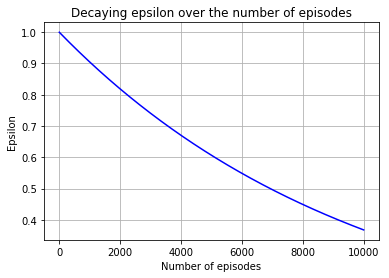

DUDL
DHDH
RDLH
HRRH


In [53]:
epsilon = 1
epsilon_min = 0.01
epsilon_decay = 0.9999
visualizing_epsilon_decay(nb_episodes, epsilon, epsilon_min, epsilon_decay)
q_table = q_learning(env, alpha, gamma, nb_episodes, nb_steps, epsilon, epsilon_min, epsilon_decay)
policy = q_to_policy(q_table)
visualize_policy(policy)

Average total reward: 0.25
###### Epsilon decaying quickly over the number of episodes


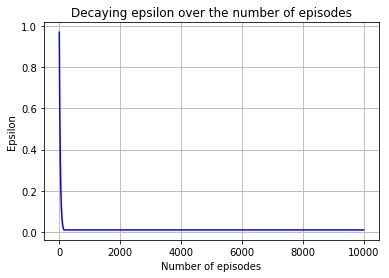

DLDU
DHDH
RDLH
HRRH


In [54]:
epsilon = 1
epsilon_min = 0.01
epsilon_decay = 0.97
visualizing_epsilon_decay(nb_episodes, epsilon, epsilon_min, epsilon_decay)
q_table = q_learning(env, alpha, gamma, nb_episodes, nb_steps, epsilon, epsilon_min, epsilon_decay)
policy = q_to_policy(q_table)
visualize_policy(policy)

Average total reward: 0.23
Overall we get a slightly better average total reward when we decay epsilon slowly than when we do it quickly, which shows that for this environment it is important to keep exploring and not focus more on exploitation than exploration too quickly.
#### Deep Q-Learning


In [45]:
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

nb_episodes = 100
state_size = 1
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
done = False
batch_size = 32

for e in range(nb_episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    for time in range(nb_steps):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
                
trained_network = agent.model

If we use the trained network to predict the Q-values of all the possible actions for each state we get the following Q-table:

In [46]:
def compute_q_table(env, network):
    q_table = np.zeros([env.observation_space.n, env.action_space.n])
    for s in range(env.observation_space.n):
        state = np.zeros(1, int)
        state[0] = s
        state = np.reshape(state, [1, state_size])
        q_table[s] = list(network.predict(state)[0])
    return q_table

print(compute_q_table(env, trained_network))

[[-0.60448682 -0.64822328 -0.62004399 -0.610021  ]
 [-0.63093698 -0.74905401 -0.63682371 -0.64011925]
 [-0.63605452 -0.75653678 -0.66441822 -0.65457392]
 [-0.6276235  -0.71005327 -0.75152701 -0.65000015]
 [-0.61563981 -0.65237719 -0.86771119 -0.6491406 ]
 [-0.60532874 -0.64021719 -0.87936395 -0.65084916]
 [-0.62819386 -0.63695633 -0.77723658 -0.63828158]
 [-0.65712279 -0.63356704 -0.65870929 -0.62256169]
 [-0.68173188 -0.62786382 -0.54825455 -0.60617757]
 [-0.70199883 -0.61983502 -0.44591433 -0.58912587]
 [-0.72221386 -0.60275799 -0.34213671 -0.56910962]
 [-0.74237984 -0.57714486 -0.23700303 -0.54629666]
 [-0.76254588 -0.55153185 -0.13186938 -0.52348369]
 [-0.78271198 -0.52591884 -0.02673575 -0.50067073]
 [-0.80287796 -0.50030565  0.07839805 -0.47785768]
 [-0.823044   -0.47469261  0.18353161 -0.45504475]]


The policy produced by this Q-table is the following one:

In [47]:
q_table = compute_q_table(env, trained_network)
policy = q_to_policy(q_table)
visualize_policy(policy)

LLLL
LHLH
RRRH
HRRH
